In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob

## Read fossil_fuel data

In [51]:
data_folder_path = '../../data/fossil_fuel/all_data/9/'
predict_folder_path = '../../output/fossil_fuel/predict_all/2class/'

In [52]:
data_files = ['1960s_coal_labeled_full_0.9.csv', '1960s_gas_labeled_full_0.9.csv', '1960s_oil_labeled_full_0.9.csv',
              '1970s_coal_labeled_full_0.9.csv', '1970s_gas_labeled_full_0.9.csv', '1970s_oil_labeled_full_0.9.csv',
              '1980s_coal_labeled_full_0.9.csv', '1980s_gas_labeled_full_0.9.csv', '1980s_oil_labeled_full_0.9.csv',
              '1990s_coal_labeled_full_0.9.csv', '1990s_gas_labeled_full_0.9.csv', '1990s_oil_labeled_full_0.9.csv']

predict_files = ['unlabeled_predictions_1960_coal_09.csv','unlabeled_predictions_1960_gas_09.csv','unlabeled_predictions_1960_oil_09.csv',
                'unlabeled_predictions_1970_coal_09.csv','unlabeled_predictions_1970_gas_09.csv','unlabeled_predictions_1970_oil_09.csv',
                'unlabeled_predictions_1980_coal_09.csv','unlabeled_predictions_1980_gas_09.csv','unlabeled_predictions_1980_oil_09.csv',
                'unlabeled_predictions_1990_coal_09.csv','unlabeled_predictions_1990_gas_09.csv','unlabeled_predictions_1990_oil_09.csv']

all_dfs = []

for data_fp, predict_fp in zip(data_files, predict_files):
    df_data = pd.read_csv(data_folder_path + data_fp)
    df_predict = pd.read_csv(predict_folder_path + predict_fp)

    filename = os.path.basename(predict_fp).replace('.csv', '')
    parts = filename.rsplit('_', 2)
    if len(parts) < 3:
        continue
    energy_type = parts[1]
    df = pd.concat([
        df_data[['date', 'p', 'newspaper_publisher']],
        df_predict[['prediction', 'confidence']]
    ], axis=1)

    df = df.rename(columns={'p': 'text', 'newspaper_publisher': 'publisher_title'})

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    df['year'] = df['date'].dt.year
    df['energy_type'] = energy_type
    
    all_dfs.append(df)

df_fossil_fuel = pd.concat(all_dfs, ignore_index=True)
df_fossil_fuel['prediction'] = df_fossil_fuel['prediction'].replace(0, -1)


## Read nuclear energy data

In [53]:
fp_data = '../../data/nuclear/all_data/combined_files.csv'
fp_predict = '../../output/nuclear/predict_all/unlabeled_predictions_checkpoint_epochs_10_batch_size_32_lr_8.177834244164004e-05_freeze_false_weight_decay_0.01_patience_3_hidden_dropout_0.0_attention_dropout_0.3_class2.csv'

df_all = pd.read_csv(fp_data)
df_predict = pd.read_csv(fp_predict)
merged_df = pd.concat([df_all, df_predict], axis=1)
columns=['date','body','title','prediction', 'confidence' ] ## title should be replaced with publisher_title
df_nuclear = merged_df[columns]
df_nuclear = df_nuclear.rename(columns={'body': 'text', 'title': 'publisher_title'})
df_nuclear = df_nuclear[df_nuclear['prediction']!= 2]
df_nuclear['prediction'] = df_nuclear['prediction'].replace(0, -1)
df_nuclear['date'] = pd.to_datetime(df_nuclear['date'], errors='coerce')
df_nuclear = df_nuclear.dropna(subset=['date'])
df_nuclear['year'] = df_nuclear['date'].dt.year
df_nuclear['energy_type']='nuclear'


## Read renewable energy data

In [54]:
fp_data = '../../data/renewable/all_data/combined_files.csv'
fp_predict = '../../output/renewable/predict_all/unlabeled_predictions_checkpoint_epochs_10_batch_size_16_lr_2.2226468679191218e-05_freeze_true_weight_decay_0.001_patience_2_hidden_dropout_0.0_attention_dropout_0.4_robbert_class2.csv'
df_all = pd.read_csv(fp_data)
df_predict = pd.read_csv(fp_predict)
merged_df = pd.concat([df_all, df_predict], axis=1)
columns=['date','body','title','prediction', 'confidence' ] ## title should be replaced with publisher_title
df_renewable = merged_df[columns]
df_renewable = df_renewable.rename(columns={'body': 'text', 'title': 'publisher_title'})
df_renewable = df_renewable[df_renewable['prediction']!= 2]
df_renewable['prediction'] = df_renewable['prediction'].replace(0, -1)
df_renewable['date'] = pd.to_datetime(df_renewable['date'], errors='coerce')
df_renewable = df_renewable.dropna(subset=['date'])
df_renewable['year'] = df_renewable['date'].dt.year
df_renewable['energy_type']='renewable'

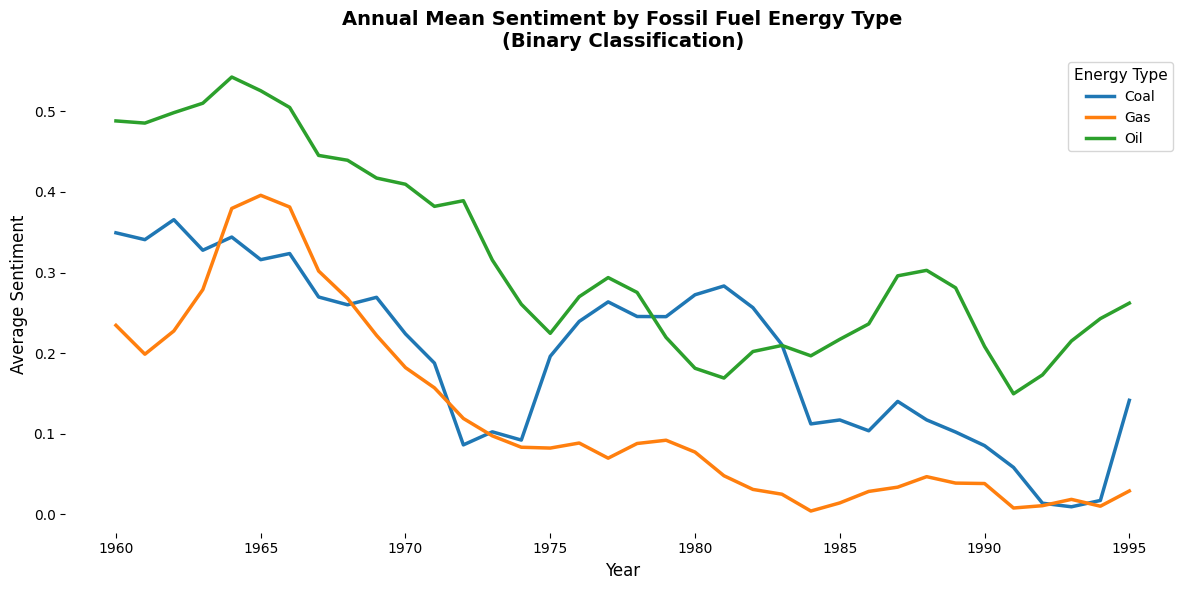

In [57]:
grouped = df_fossil_fuel.groupby(['year', 'energy_type'])['prediction'].mean().reset_index()
pivot_df = grouped.pivot(index='year', columns='energy_type', values='prediction').fillna(0)
smoothed_df = pivot_df.rolling(window=3, min_periods=1).mean()

plt.style.use('default') 
plt.figure(figsize=(12, 6))

for energy in smoothed_df.columns:
    plt.plot(
        smoothed_df.index,
        smoothed_df[energy],
        label=energy.capitalize(),
        linewidth=2.5,
        marker='',  # or 'o' if you want dots
    )
    
plt.title(
    'Annual Mean Sentiment by Fossil Fuel Energy Type\n(Binary Classification)',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)

# Fancy legend
plt.legend(title="Energy Type", fontsize=10, title_fontsize=11)
plt.grid(False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


## Oil:
- 1973: OPEC imposed an oil embargo in response to Western support for Israel, negative due to shortages, high prices, and dependence on politically unstable suppliers.
- 1975-80: There may have been a return of optimism or acceptance as the crisis passed and the economy adjusted.
- 1979: second oil shock (caused by the Iranian Revolution and later the Iran-Iraq War)
- 1981-82: global oil glut began around this time, leading to falling oil prices, which may have boosted public sentiment again.
- 1988: Oil prices were relatively low and stable in the mid-to-late 1980s.
- 1991: Iraq’s invasion of Kuwait triggered fears of supply disruption, and oil prices spiked temporarily.

## Gas
1961: uncertainty or skepticism about the actual potential of the gas field, Whether infrastructure would be built in time,
or Economic viability.
1963–1965, gas extraction and distribution were ramping up quickly.
1977: The term "Dutch disease" was coined in 1977 to describe the economic phenomenon where a resource boom—in this case, natural gas—led to a decline in other sectors like manufacturing due to currency appreciation.

## Coal
1972: first UN Conference on the Human Environment (Stockholm, 1972) marked a turning point in public discourse.Coal was increasingly seen as dirty, polluting, and outdated, especially in urban areas
1975: because of oil crisis, The Netherlands, like others, explored reviving or maintaining coal to reduce oil dependency.
1977 Spike:
In the wake of the 1973 oil crisis, energy security became a national priority.
The Netherlands began re-evaluating coal as a reliable domestic energy source, especially as concerns over oil dependency grew.
Public and political discourse around diversifying energy supply likely contributed to a temporary rise in positive sentiment toward coal.
1981 Spike:
Following the 1979 second oil crisis, urgency increased to reduce reliance on imported oil.
The government planned investments in new coal-fired plants, notably Hemweg 8 and Maasvlakte.
These moves were seen as strategic for energy independence and long-term stability, boosting media and political support for coal.

1984: Globally, the Brundtland Commission (formed in 1983) began promoting sustainable development, shifting narratives toward long-term environmental responsibility. Countries in Europe were beginning to adopt stricter emissions regulations, putting pressure on coal.

1987, advancements in clean coal technology made it possible to burn coal more efficiently and with fewer emissions, thus making it more palatable to both the government and the public.
1992, the Earth Summit (also known as the Rio Earth Summit), about reducing greenhouse gas emissions.
1995: The increase in coal usage can be attributed to economic recovery, a rise in energy demand, the availability of cheaper coal from global markets, and technological advancements in coal plants that allowed for more efficient and cleaner burning of coal

In [58]:
df = pd.concat([
        df_fossil_fuel,
        df_nuclear,
        df_renewable], axis=0)

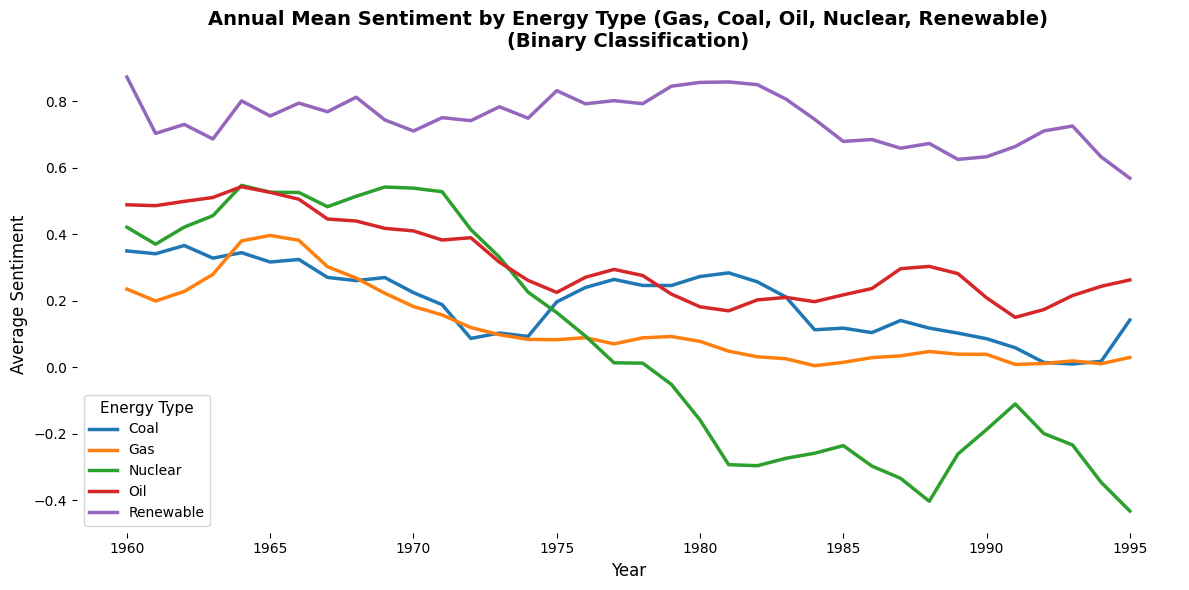

In [64]:
grouped = df.groupby(['year', 'energy_type'])['prediction'].mean().reset_index()

pivot_df = grouped.pivot(index='year', columns='energy_type', values='prediction').fillna(0)

smoothed_df = pivot_df.rolling(window=3, min_periods=1).mean()

plt.style.use('default') 
plt.figure(figsize=(12, 6))

for energy in smoothed_df.columns:
    plt.plot(
        smoothed_df.index,
        smoothed_df[energy],
        label=energy.capitalize(),
        linewidth=2.5,
        marker='',  # or 'o' if you want dots
    )
    
plt.title(
    'Annual Mean Sentiment by Energy Type (Gas, Coal, Oil, Nuclear, Renewable)\n(Binary Classification)',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)

# Fancy legend
plt.legend(title="Energy Type", fontsize=10, title_fontsize=11)
plt.grid(False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [60]:
avg_df_fossil_fuel = df_fossil_fuel.groupby('year')['prediction'].mean().reset_index()
avg_df_fossil_fuel['energy_type'] = 'fossil_fuel'

In [61]:
df3 = pd.concat([
        avg_df_fossil_fuel,
        df_nuclear,
        df_renewable], axis=0)

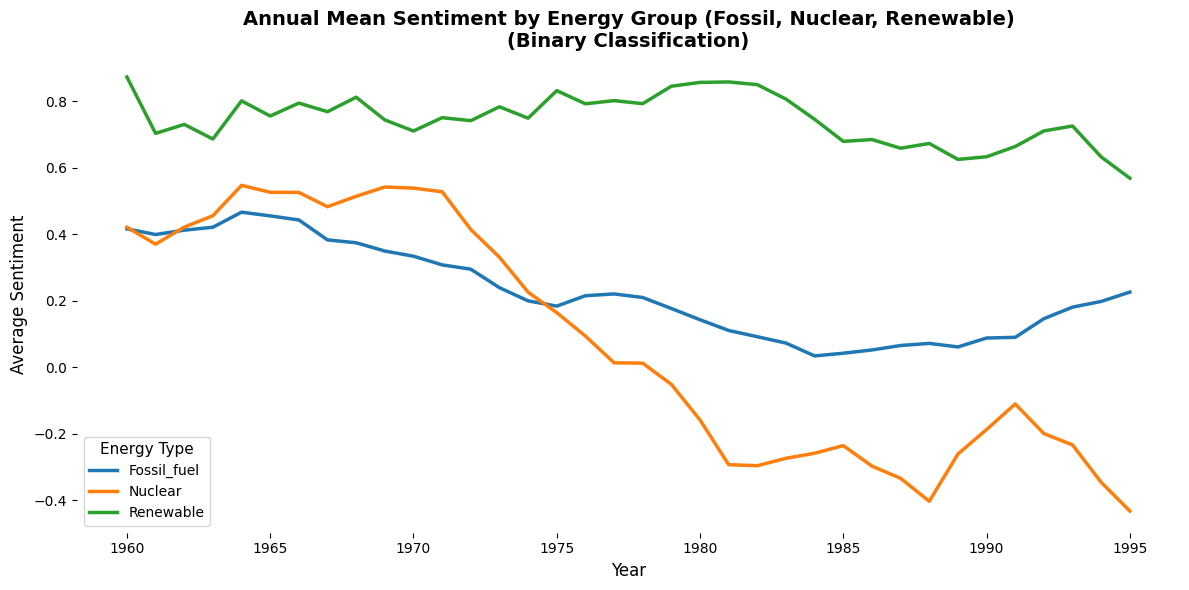

In [63]:
grouped = df3.groupby(['year', 'energy_type'])['prediction'].mean().reset_index()

pivot_df = grouped.pivot(index='year', columns='energy_type', values='prediction').fillna(0)

smoothed_df = pivot_df.rolling(window=3, min_periods=1).mean()

plt.style.use('default') 
plt.figure(figsize=(12, 6))

for energy in smoothed_df.columns:
    plt.plot(
        smoothed_df.index,
        smoothed_df[energy],
        label=energy.capitalize(),
        linewidth=2.5,
        marker='',  # or 'o' if you want dots
    )
    
plt.title(
    'Annual Mean Sentiment by Energy Group (Fossil, Nuclear, Renewable)\n(Binary Classification)',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)

# Fancy legend
plt.legend(title="Energy Type", fontsize=10, title_fontsize=11)
plt.grid(False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()